In [2]:
#Load modules
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from datetime import datetime
from IPython.display import Image
import scipy.io
import pandas as pd
from IPython.display import display, clear_output
import sys, os
import warnings


warnings.filterwarnings('ignore')
from sklearn.mixture import GaussianMixture

import itertools

from sklearn.cluster import SpectralClustering, AffinityPropagation
import sklearn
%matplotlib inline

Generate mixture of kappa/Gaussian distributions (k=2 kappa, k=200 Gaussian)

200.0
200.0
200.0
200.0
[4.947572129940825, 4.304885667653246, 0.2229322847006308]
[4.473847958200564, 5.40491279941558, 2.9580915498147426]
[6.131290352253311, 3.1283962742994422, 5.520904417393016]
[2.724303859581075, 1.7026672831394476, 4.025524998655479]
[2.0067553894000074, 1.9822370470616748, 2.0209170279283066]
[1.994597057188247, 1.9769351740499828, 2.0166098711943965]
[2.0344679230626475, 1.9772352292975803, 1.983899931615078]
[2.0469917158217186, 2.0273813639424985, 1.9848180720647655]


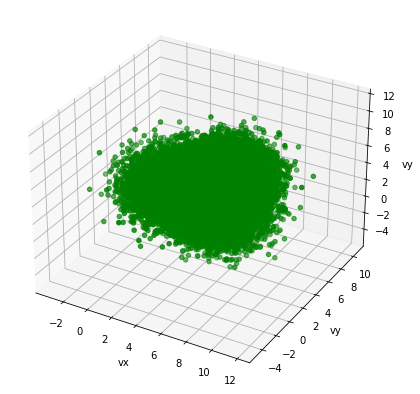

In [6]:
Np=10000 #Number of particles generated from distribution

from random import randint
import random

k_kappa_min=2
k_kappa_max=6  

NC=4   #Amount of clusters
b=7    #Maximum separation between means of the clusters
v0x=b*np.random.rand(NC) 
v0y=b*np.random.rand(NC)
v0z=b*np.random.rand(NC)
vpkx=[]
vpky=[] 
vpkz=[]
for ncomp in range(0,NC):
    
    k_kappa=random.uniform(k_kappa_min, k_kappa_max) #Use this line if you want to generate clusters from different kappa values
#     k_kappa=2.1 #k_kappa=2 for kappa distribution - k_kappa=200 for full gaussian


    uth=np.sqrt(2) #Thermal velocities
    vth=np.sqrt(2)
    apar = uth*uth*2.0*(k_kappa-1.5)/k_kappa
    aperp = vth*vth*2.0*(k_kappa-1.5)/k_kappa
    
    theta = 2.0 * np.pi * np.random.rand(Np)
    vpar=np.sqrt(k_kappa*apar*(pow(np.random.rand(Np),(-1.0/(k_kappa-0.5)))-1.0))*np.cos(theta)
    vperp=np.sqrt(k_kappa*aperp*(1.0+vpar*vpar/(k_kappa*apar+1e-10))*(pow((1.0-np.random.rand(Np)),(-1.0/k_kappa))-1.0))

    theta = 2*np.pi*np.random.rand(Np)
    vpkx2=v0x[ncomp]+vpar
    vpky2=v0y[ncomp]+vperp * np.cos(theta)
    vpkz2=v0z[ncomp]+vperp * np.sin(theta)
    
    vpkx.append(vpkx2)
    vpky.append(vpky2)
    vpkz.append(vpkz2)

    

vpkx = list(np.concatenate(vpkx). flat)
vpky = list(np.concatenate(vpky). flat)
vpkz = list(np.concatenate(vpkz). flat)   
Xdata=np.array([vpkx,vpky,vpkz])

Xdata=np.conjugate(Xdata).T  
#print(Xdata.shape)
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
 
# Creating cluster plot
ax.scatter3D(Xdata[:,0], Xdata[:,1], Xdata[:,2], color = "green")
ax.set_xlabel('vx')
ax.set_ylabel('vy')
ax.set_zlabel('vy')

# ax.axes.set_xlim3d(left=0, right=12) 
# ax.axes.set_ylim3d(bottom=0, top=12) 
# ax.axes.set_zlim3d(bottom=0, top=12)

# Means of 4 clusters
print([np.mean(Xdata[:Np,0]),np.mean(Xdata[:Np,1]),np.mean(Xdata[:Np,2])])
print([np.mean(Xdata[Np:2*Np,0]),np.mean(Xdata[Np:2*Np,1]),np.mean(Xdata[Np:2*Np,2])])
print([np.mean(Xdata[2*Np:3*Np,0]),np.mean(Xdata[2*Np:3*Np,1]),np.mean(Xdata[2*Np:3*Np,2])])
print([np.mean(Xdata[3*Np:,0]),np.mean(Xdata[3*Np:,1]),np.mean(Xdata[3*Np:,2])])
#variances of 4 clusters
print([np.mean(np.abs(Xdata[:Np,0]-np.mean(Xdata[:Np,0]))**2),np.mean(np.abs(Xdata[:Np,1]-np.mean(Xdata[:Np,1]))**2),np.mean(np.abs(Xdata[:Np,2]-np.mean(Xdata[:Np,2]))**2)])
print([np.mean(np.abs(Xdata[Np:2*Np,0]-np.mean(Xdata[Np:2*Np,0]))**2),np.mean(np.abs(Xdata[Np:2*Np,1]-np.mean(Xdata[Np:2*Np,1]))**2),np.mean(np.abs(Xdata[Np:2*Np,2]-np.mean(Xdata[Np:2*Np,2]))**2)])
print([np.mean(np.abs(Xdata[2*Np:3*Np,0]-np.mean(Xdata[2*Np:3*Np,0]))**2),np.mean(np.abs(Xdata[2*Np:3*Np,1]-np.mean(Xdata[2*Np:3*Np,1]))**2),np.mean(np.abs(Xdata[2*Np:3*Np,2]-np.mean(Xdata[2*Np:3*Np,2]))**2)])
print([np.mean(np.abs(Xdata[3*Np:,0]-np.mean(Xdata[3*Np:,0]))**2),np.mean(np.abs(Xdata[3*Np:,1]-np.mean(Xdata[3*Np:,1]))**2),np.mean(np.abs(Xdata[3*Np:,2]-np.mean(Xdata[3*Np:,2]))**2)])
# show plot
plt.show()

GMM silhouette and CH score (slow)

In [191]:
fig.clear()

Sil_Score=[]
CH_score=[]

n_components_range= range(2,10) #select the amount of components will be tested
clusters=list(range(2,10))

for n_components in range(2,10):
    gmm = GaussianMixture(n_components,n_init=20, random_state=0)
    labels=gmm.fit_predict(Xdata)
    Sil_Score.append(sklearn.metrics.silhouette_score(Xdata,labels))
    CH_score.append(sklearn.metrics.calinski_harabasz_score(Xdata,labels))
plt.rcParams['figure.figsize'] = [10, 2]    
  
plt.subplot(1, 2, 1)
plt.plot(clusters,Sil_Score,'-o')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette-score')


plt.subplot(1, 2, 2) # index 2

plt.plot(clusters,CH_score,'-o','r')
plt.xlabel('Number of clusters')
plt.ylabel('Calinski-Harabasz-score')

GMM BIC (fast)

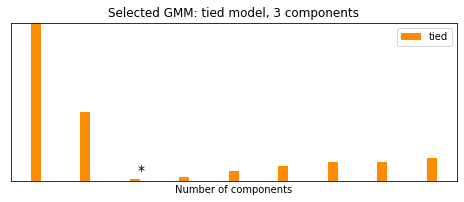

In [4]:
fig.clear()

lowest_bic = np.infty
bic= []
n_components_range= range(1,10)
cv_types = ["tied"] #Choose covariance type

for cv_type in cv_types:
    for n_components in n_components_range:
    
        gmm = GaussianMixture(n_components,covariance_type=cv_type, random_state=0,tol=1,max_iter=100).fit(Xdata)

        bic.append(gmm.bic(Xdata))
        if bic[-1] < lowest_bic:
                lowest_bic = bic[-1]
                best_gmm = gmm
bic = np.array(bic)
color_iter = itertools.cycle(["darkorange"])
clf = best_gmm
bars = []

# Plot the BIC scores
plt.figure(figsize=(8, 6))
spl = plt.subplot(2, 1, 1)
for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
    xpos = np.array(n_components_range) + 0.2 * (i - 2)
    bars.append(
        plt.bar(
            xpos,
            bic[i * len(n_components_range) : (i + 1) * len(n_components_range)],
            width=0.2,
            color=color,
        )
    )
plt.xticks(n_components_range)
plt.ylim([bic.min() * 1.01 - 0.01 * bic.max(), bic.max()])
plt.title("BIC score per model")
xpos = (
    np.mod(bic.argmin(), len(n_components_range))
    + 0.65
    + 0.2 * np.floor(bic.argmin() / len(n_components_range))
)
plt.text(xpos, bic.min() * 0.97 + 0.03 * bic.max(), "*", fontsize=14)
spl.set_xlabel("Number of components")
spl.legend([b[0] for b in bars], cv_types)

plt.xticks(())
plt.yticks(())
plt.title(
    f"Selected GMM: {best_gmm.covariance_type} model, "
    f"{best_gmm.n_components} components"
)
plt.subplots_adjust(hspace=0.35, bottom=0.02)
plt.show()

[2.2822227127571395, 0.5732287542271409, 5.4803973522159986]
[5.898978332233643, 1.1690432717709613, 1.7891636803575315]
[array([2.15701608, 2.23102418, 1.86297387]), array([2.1007612 , 2.04524223, 2.0447569 ])]


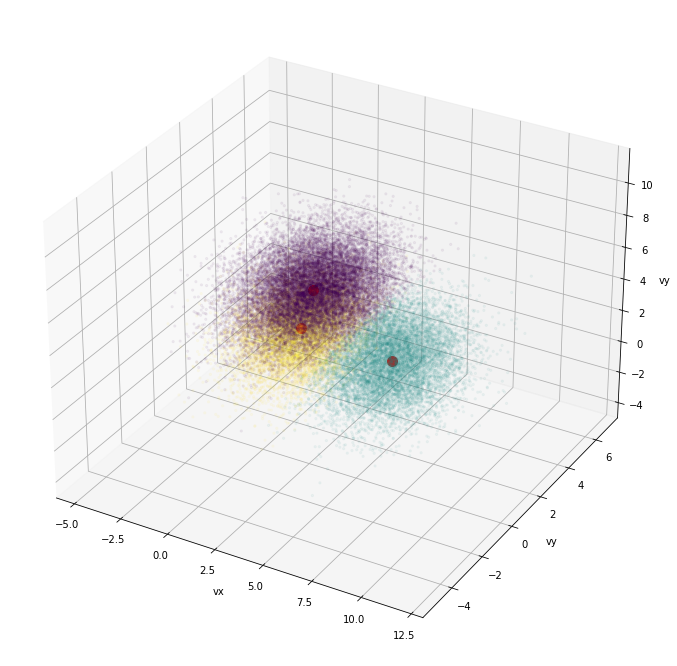

In [5]:
fig.clear()
#Recalculate the labels of the selected model
my_model = GaussianMixture(n_components=best_gmm.n_components,random_state=0,covariance_type='full')
my_model.fit(Xdata)

gmm_labels = my_model.predict(Xdata)
gmm_centers = my_model.means_
gmm_labels.shape

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')
ax.scatter(vpkx,vpky,vpkz,marker='.', c=gmm_labels,alpha=0.05)

# ax.axes.set_xlim3d(left=0, right=12) 
# ax.axes.set_ylim3d(bottom=0, top=12) 
# ax.axes.set_zlim3d(bottom=0, top=12)

ax.set_xlabel('vx')
ax.set_ylabel('vy')
ax.set_zlabel('vy')

#Coordinates of the means of 4 clusters
print([gmm_centers[0,0],gmm_centers[0,1],gmm_centers[0,2]])
print([gmm_centers[1,0],gmm_centers[1,1],gmm_centers[1,2]])
print([gmm_centers[2,0],gmm_centers[2,1],gmm_centers[2,2]])
print([gmm_centers[3,0],gmm_centers[3,1],gmm_centers[3,2]])

cov=my_model.covariances_
#Coordinates of the variances of 4 clusters
print([np.diag(cov[i]) for i in range(0,2)])

for i in range(0,best_gmm.n_components):
    ax.plot(gmm_centers[i,0],gmm_centers[i,1],gmm_centers[i,2],'o', color='red',markersize='10')

# for angle in range(0, 360, 40):
#     ax.view_init(5, angle)
#     display(fig)
#     clear_output(wait = True)
#     plt.pause(0.1)

Spectral Clustering

432.35772347450256

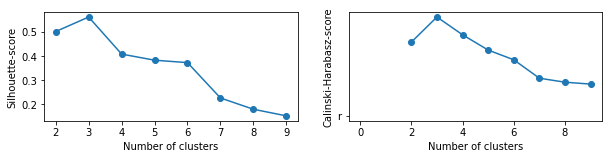

In [168]:
fig.clear()

import time 
from sklearn.cluster import SpectralClustering
t= time.time()

Sil_Score=[]
CH_score=[]

clusters=list(range(2,10))

for i in range(2,10):
    clustering = SpectralClustering(n_clusters=i,
         assign_labels='discretize', 
        random_state=0,affinity='nearest_neighbors',n_jobs=8).fit(Xdata)
    Sil_Score.append(sklearn.metrics.silhouette_score(Xdata,clustering.labels_))
    CH_score.append(sklearn.metrics.calinski_harabasz_score(Xdata,clustering.labels_))
plt.rcParams['figure.figsize'] = [10, 2]    
  
plt.subplot(1, 2, 1)
plt.plot(clusters,Sil_Score,'-o')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette-score')


plt.subplot(1, 2, 2) # index 2

plt.plot(clusters,CH_score,'-o','r')
plt.xlabel('Number of clusters')
plt.ylabel('Calinski-Harabasz-score')
elapsed=time.time()-t
elapsed